# international_migration Network Analysis

This note works with international migration with unemployment  

Meta Migration Data: https://data.humdata.org/dataset/international-migration-flows)    

Special countries: BA, UA, XK, UK/GB, EL/GR 

In [1]:
import os
import gc
import rasterio
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
import seaborn as sns
import geopandas as gpd
from pathlib import Path
from osgeo import gdal, osr
import dask_geopandas as dgpd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
from scipy.stats import linregress
from pyvis.network import Network

BASE_DIR = Path('/Users/wenlanzhang/PycharmProjects/Mapineq/src/data-wrangling/')
DATA_DIR = Path('/Users/wenlanzhang/Downloads/PhD_UCL/Data/Oxford')

# Load & Clean Migration Data

In [2]:
# Step 1: Load international migration data
def load_international_migration(filepath):
    df = pd.read_csv(filepath)
    df['year'] = pd.to_datetime(df['migration_month']).dt.year
    df['month'] = pd.to_datetime(df['migration_month']).dt.month

    # Country code mapping
    # country_code_mapping = {'GR': 'EL', 'GB': 'UK'}
    # df['country_from'] = df['country_from'].replace(country_code_mapping)
    # df['country_to'] = df['country_to'].replace(country_code_mapping)
    
    return df

migration_df = load_international_migration(DATA_DIR / "Migration/international_migration_flow.csv")
migration_df

,country_from,country_to,migration_month,num_migrants,year,month
0,AD,AE,2019-01,12,2019,1
1,AD,AE,2019-02,2,2019,2
2,AD,AE,2019-03,1,2019,3
3,AD,AE,2019-04,7,2019,4
4,AD,AE,2019-05,0,2019,5
...,...,...,...,...,...,...
1563149,ZW,ZM,2022-08,138,2022,8
1563150,ZW,ZM,2022-09,162,2022,9
1563151,ZW,ZM,2022-10,149,2022,10
1563152,ZW,ZM,2022-11,104,2022,11


In [3]:
max_row = migration_df.loc[migration_df['num_migrants'].idxmax()]
max_row

country_from            UA
country_to              PL
migration_month    2022-05
num_migrants        163937
year                  2022
month                    5
Name: 1439985, dtype: object

In [4]:
# Check for missing values
print("\nMissing values per column (before cleaning):")
print(migration_df.isnull().sum())


Missing values per column (before cleaning):
country_from       8640
country_to         8640
migration_month       0
num_migrants          0
year                  0
month                 0
dtype: int64


In [5]:
migration_df_cleaned = migration_df.dropna()  # drop missing data
migration_df_cleaned = migration_df_cleaned[migration_df_cleaned['num_migrants'] > 0]  # filter num_migrants > 0

# Result preview after cleaning
print(f"\nNumber of rows after cleaning: {len(migration_df_cleaned)}")
print("Cleaned data preview:")
display(migration_df_cleaned.head())

# # Final missing value check
# print("\nMissing values per column (after cleaning):")
# print(migration_df_cleaned.isnull().sum())


Number of rows after cleaning: 939922
Cleaned data preview:


,country_from,country_to,migration_month,num_migrants,year,month
0,AD,AE,2019-01,12,2019,1
1,AD,AE,2019-02,2,2019,2
2,AD,AE,2019-03,1,2019,3
3,AD,AE,2019-04,7,2019,4
5,AD,AE,2019-06,14,2019,6


In [6]:
df_2019 = migration_df_cleaned[migration_df_cleaned['year'] == 2019].copy()

# Group by country_from, country_to, and year to get yearly totals
df_yearly_2019 = (
    df_2019
    .groupby(['country_from', 'country_to', 'year'], as_index=False)
    .agg({'num_migrants': 'sum'})
)

# Now add placeholder columns to match original structure
# Set month to None or some neutral value since it's not meaningful yearly
# df_yearly_2019['month'] = None
df_yearly_2019['migration_month'] = df_yearly_2019['year'].astype(str)  # e.g., '2019'

# Optional: reorder columns to match original order
df_yearly_2019 = df_yearly_2019[['country_from', 'country_to', 'migration_month', 'num_migrants']]
df_yearly_2019

,country_from,country_to,migration_month,num_migrants
0,AD,AE,2019,58
1,AD,AF,2019,16
2,AD,AL,2019,37
3,AD,AM,2019,22
4,AD,AO,2019,47
...,...,...,...,...
32193,ZW,WS,2019,38
32194,ZW,XK,2019,54
32195,ZW,YE,2019,52
32196,ZW,ZA,2019,47755


# Basic Flow Statistics

In [7]:
# Summary statistics of migration flows
print("Migration flow statistics:")
print(df_yearly_2019['num_migrants'].describe())

# Number of unique countries
num_origin_countries = migration_df_cleaned['country_from'].nunique()
num_destination_countries = migration_df_cleaned['country_to'].nunique()

print(f"\nNumber of unique origin countries: {num_origin_countries}")
print(f"Number of unique destination countries: {num_destination_countries}")

Migration flow statistics:
count     32198.000000
mean        972.923039
std        9915.524331
min           1.000000
25%          30.000000
50%          47.000000
75%         111.000000
max      856223.000000
Name: num_migrants, dtype: float64

Number of unique origin countries: 180
Number of unique destination countries: 180


# Full Migration Network (Static Network)

- High density (~1), high reciprocity (1), means your data records nearly all possible migration relations.
- Some countries (US, IN, SA, AE) clearly dominate in inflow and outflow.
- Interesting that some small countries (FM, BN, VC) have high betweenness centrality — suggesting "bridging" roles.

## Build full graph and basic stats

In [8]:
# Aggregate total number of migrants per country pair
df_agg = df_yearly_2019.groupby(['country_from', 'country_to'])['num_migrants'].sum().reset_index()

# Build full directed graph
G = nx.DiGraph()
for idx, row in df_agg.iterrows():
    G.add_edge(row['country_from'], row['country_to'], weight=row['num_migrants'])

# Basic graph stats
print(f"\nFull Network Statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Network density
density = nx.density(G)
print(f"Network density: {density:.4f}")

# Reciprocity
reciprocity = nx.overall_reciprocity(G)
print(f"Network reciprocity: {reciprocity:.4f}")

# Flow range
print(f"Flow range: min={df_agg['num_migrants'].min()}, max={df_agg['num_migrants'].max()}")


Full Network Statistics:
Number of nodes: 180
Number of edges: 32198
Network density: 0.9993
Network reciprocity: 0.9997
Flow range: min=1, max=856223


## Degree and Strength

In [9]:
# Degree
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())

print(f"\nAverage in-degree: {sum(in_degree.values()) / len(in_degree):.2f}")
print(f"Average out-degree: {sum(out_degree.values()) / len(out_degree):.2f}")

# Strength
in_strength = dict(G.in_degree(weight='weight'))
out_strength = dict(G.out_degree(weight='weight'))

# Top 5 by inflow
print(f"\nTop 5 countries by migration inflow:")
for country, strength in sorted(in_strength.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{country}: {strength}")

# Top 5 by outflow
print(f"\nTop 5 countries by migration outflow:")
for country, strength in sorted(out_strength.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{country}: {strength}")


Average in-degree: 178.88
Average out-degree: 178.88

Top 5 countries by migration inflow:
US: 2283443
SA: 1599334
IN: 1544724
AE: 1248096
CO: 991173
PH: 960554
GB: 856129
ES: 768738
DE: 756510
CA: 749657

Top 5 countries by migration outflow:
IN: 2520488
SA: 2032124
VE: 1701418
US: 1242349
PH: 1113302
MY: 926864
AE: 769781
BD: 719978
PK: 704759
GB: 670532


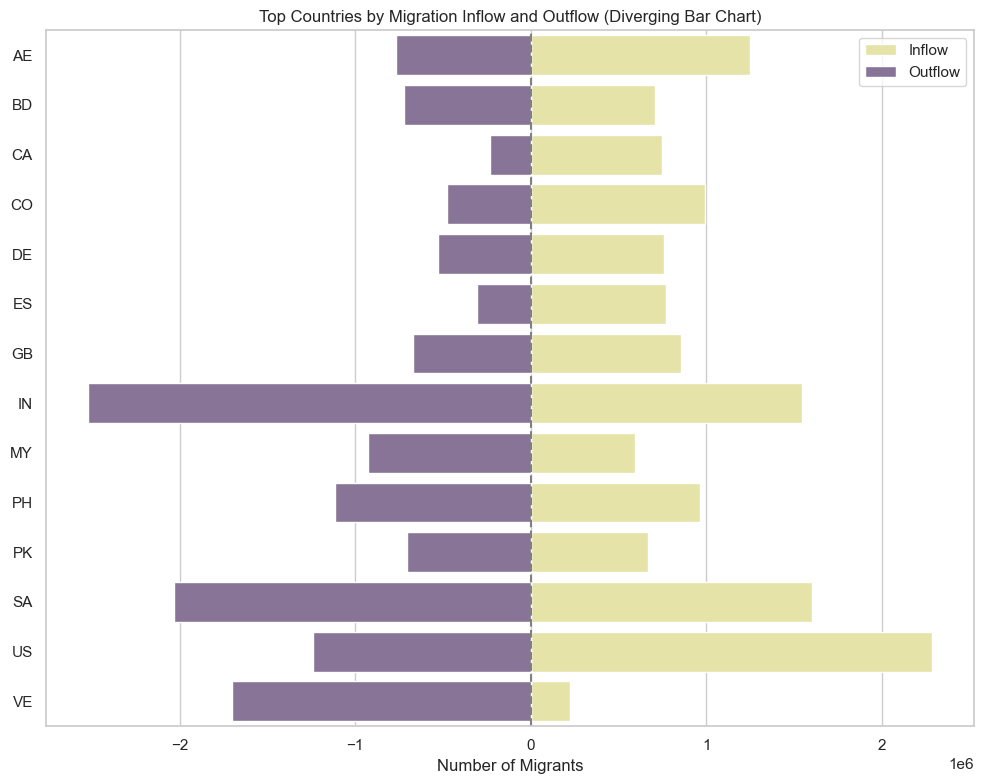

In [10]:
# This is not correct case it is top 10 + top 10 😂

# Convert to Series
out_series = pd.Series(out_strength)
in_series = pd.Series(in_strength)

# Get top 10 countries by out_strength and in_strength
top_out = out_series.sort_values(ascending=False).head(10)
top_in = in_series.sort_values(ascending=False).head(10)

# Combine countries
top_countries = sorted(set(top_out.index) | set(top_in.index))

# Build DataFrame for Seaborn
data = pd.DataFrame({
    'Country': top_countries,
    'Inflow': [in_series.get(c, 0) for c in top_countries],
    'Outflow': [-out_series.get(c, 0) for c in top_countries],  # Negative for left bar
})

# Melt to long format for Seaborn
df_melted = data.melt(id_vars='Country', var_name='Flow Type', value_name='Migrants')

# Plot
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

sns.barplot(
    data=df_melted,
    y='Country',
    x='Migrants',
    hue='Flow Type',
    palette={'Inflow': '#f1ed9d', 'Outflow': '#886e9d'},
    dodge=False
)

plt.axvline(0, color='gray', linestyle='--')
plt.title('Top Countries by Migration Inflow and Outflow (Diverging Bar Chart)')
plt.xlabel('Number of Migrants')
plt.ylabel('')
plt.legend(title='')
plt.tight_layout()
plt.savefig("migration_diverging_chart_seaborn.png", dpi=300, bbox_inches='tight')
plt.show()

## Centrality Measures

In [11]:
# Betweenness centrality
bet_centrality = nx.betweenness_centrality(G, weight='weight', normalized=True)

# Eigenvector centrality
eigen_centrality = nx.eigenvector_centrality_numpy(G, weight='weight')

# Top 5 by betweenness
top_betweenness = sorted(bet_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print(f"\nTop 5 countries by betweenness centrality:")
for country, centrality in top_betweenness:
    print(f"{country}: {centrality:.4f}")


Top 5 countries by betweenness centrality:
LS: 0.0511
MW: 0.0486
GD: 0.0475
VU: 0.0465
BO: 0.0449


### PageRank (importance in terms of flow passing through)

In [12]:
pagerank = nx.pagerank(G, weight='weight')
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 countries by PageRank:", top_pagerank)


Top 5 countries by PageRank: [('US', 0.06096523804978747), ('IN', 0.036453948091097206), ('GB', 0.03352489271164858), ('DE', 0.03004972851649948), ('SA', 0.02953952195852428)]


### Closeness Centrality (how close a node is to all others)

In [13]:
closeness = nx.closeness_centrality(G, distance='weight')
top_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 countries by closeness centrality:", top_closeness)


Top 5 countries by closeness centrality: [('LS', 0.06105047748976808), ('DJ', 0.06039136302294197), ('SZ', 0.05990629183400268), ('NI', 0.05958721704394141), ('GD', 0.059369817578772806)]


### Katz Centrality
(for strongly connected graphs with high density, Katz centrality can highlight influence propagation)

In [14]:
katz_centrality = nx.katz_centrality_numpy(G, weight='weight')
top_katz = sorted(katz_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 countries by Katz centrality:", top_katz)

Top 5 countries by Katz centrality: [('VC', 0.3549862488530957), ('LV', 0.24979346253445409), ('AD', 0.23626755241438965), ('MT', 0.20240956030813195), ('KI', 0.19154192182451693)]


## Community Detection
In this section, we detect communities in the migration network.  
This can reveal clusters of countries with higher migration flow between them.
We use the Louvain algorithm, which optimizes modularity to find good community partitions.

In [15]:
# Convert to undirected graph for Louvain (works better this way)
G_undirected = G.to_undirected()

# Run Louvain community detection
import community.community_louvain as community_louvain

partition = community_louvain.best_partition(G_undirected, weight='weight')

# Number of communities
num_communities = len(set(partition.values()))
print(f"Number of communities detected: {num_communities}")

# Size of each community
from collections import Counter
community_sizes = Counter(partition.values())
print("Community sizes:", community_sizes)

# Example: list countries in largest community
largest_community_id = community_sizes.most_common(1)[0][0]
largest_community_countries = [country for country, comm in partition.items() if comm == largest_community_id]

print(f"Countries in largest community ({len(largest_community_countries)} countries):")
print(largest_community_countries)

Number of communities detected: 6
Community sizes: Counter({0: 74, 4: 35, 1: 27, 3: 17, 5: 17, 2: 10})
Countries in largest community (74 countries):
['AD', 'AF', 'AL', 'AM', 'AT', 'AZ', 'BA', 'BB', 'BE', 'BG', 'BY', 'CH', 'CV', 'CY', 'CZ', 'DE', 'DJ', 'DK', 'DZ', 'EE', 'ER', 'FI', 'FR', 'GB', 'GD', 'GE', 'GR', 'HR', 'HU', 'IE', 'IL', 'IQ', 'IS', 'IT', 'KG', 'KI', 'KM', 'KZ', 'LB', 'LC', 'LT', 'LU', 'LV', 'MA', 'MD', 'ME', 'MG', 'MK', 'MT', 'MU', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'RU', 'SB', 'SE', 'SI', 'SK', 'SR', 'ST', 'SY', 'TJ', 'TM', 'TN', 'TR', 'UA', 'UZ', 'VC', 'VU', 'WS', 'XK']


## Flow Imbalance Analysis
In this section, we compute **net migration flow** for each country:  
**Net flow = inflow - outflow**  
Countries with high net inflow are migration "magnets", while high net outflow countries are "sources" of migrants.

In [16]:
# Compute net flow: inflow - outflow
net_flow = {country: in_strength.get(country, 0) - out_strength.get(country, 0) for country in G.nodes()}

# Top net inflow countries
top_net_inflow = sorted(net_flow.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 net inflow countries:")
for country, value in top_net_inflow:
    print(f"{country}: {value}")

# Top net outflow countries
top_net_outflow = sorted(net_flow.items(), key=lambda x: x[1], reverse=False)[:5]
print("\nTop 5 net outflow countries:")
for country, value in top_net_outflow:
    print(f"{country}: {value}")

Top 5 net inflow countries:
US: 1041094
CA: 517841
CO: 514224
AE: 478315
ES: 463431

Top 5 net outflow countries:
VE: -1479581
IN: -975764
SA: -432790
MY: -335036
BR: -188428


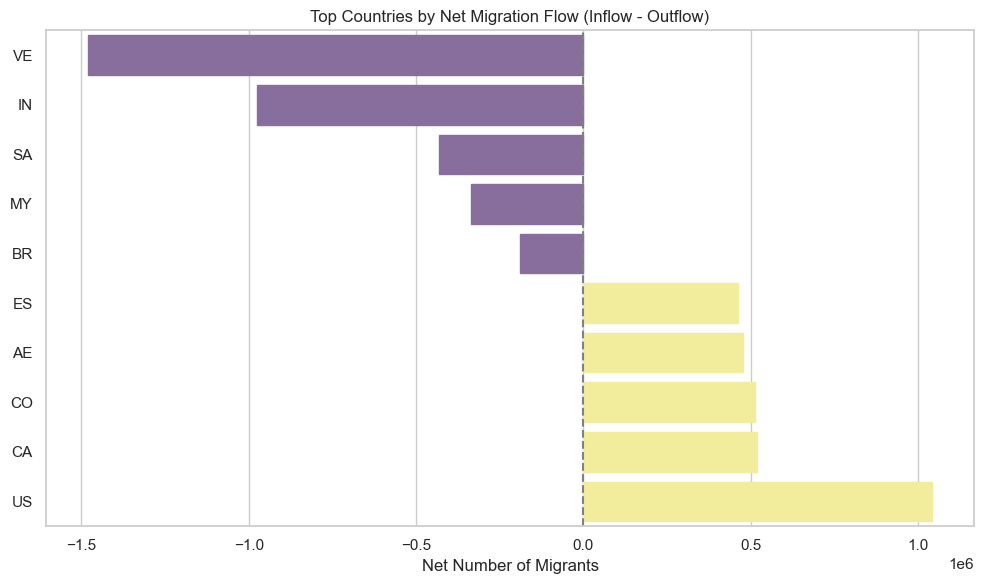

In [17]:
# Get top 5 net inflow and top 5 net outflow countries
top_net_inflow = sorted(net_flow.items(), key=lambda x: x[1], reverse=True)[:5]
top_net_outflow = sorted(net_flow.items(), key=lambda x: x[1])[:5]

top_countries = [c for c, _ in top_net_inflow] + [c for c, _ in top_net_outflow]

df_net = pd.DataFrame({
    'Country': top_countries,
    'Net Flow': [net_flow[c] for c in top_countries]
})

# Sort for plotting (so negative values on top or bottom)
df_net = df_net.sort_values('Net Flow')

# Add a color column based on positive or negative net flow
df_net['Color'] = df_net['Net Flow'].apply(lambda x: '#f1ed9d' if x > 0 else '#886e9d')

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Plot bars with colors from the 'Color' column and no hue
sns.barplot(
    data=df_net,
    y='Country',
    x='Net Flow',
    palette=None,   # no palette because no hue
    dodge=False,
    color=None,     # will set color individually below
)

# Manually color bars
ax = plt.gca()
for i, bar in enumerate(ax.patches):
    bar.set_color(df_net.iloc[i]['Color'])

plt.axvline(0, color='gray', linestyle='--')
plt.title('Top Countries by Net Migration Flow (Inflow - Outflow)')
plt.xlabel('Net Number of Migrants')
plt.ylabel('')
plt.tight_layout()
plt.savefig("migration_net_flow_diverging_chart.png", dpi=300, bbox_inches='tight')
plt.show()

## Temporal Network Dynamics
### Nodes and Edges per Year

In [18]:
# Analyze network per year
for year in migration_df_cleaned['year'].unique():
    df_year = migration_df_cleaned[migration_df_cleaned['year'] == year]
    df_agg_year = df_year.groupby(['country_from', 'country_to'])['num_migrants'].sum().reset_index()

    G_year = nx.DiGraph()
    for idx, row in df_agg_year.iterrows():
        G_year.add_edge(row['country_from'], row['country_to'], weight=row['num_migrants'])

    print(f"\nYear {year} Statistics:")
    print(f"Number of nodes: {G_year.number_of_nodes()}")
    print(f"Number of edges: {G_year.number_of_edges()}")


Year 2019 Statistics:
Number of nodes: 180
Number of edges: 32198

Year 2020 Statistics:
Number of nodes: 180
Number of edges: 32203

Year 2021 Statistics:
Number of nodes: 180
Number of edges: 32181

Year 2022 Statistics:
Number of nodes: 180
Number of edges: 32193


### Density per Year
We compute network density for each year to see if connectivity changes over time.

In [19]:
for year in sorted(migration_df_cleaned['year'].unique()):
    df_year = migration_df_cleaned[migration_df_cleaned['year'] == year]
    df_agg_year = df_year.groupby(['country_from', 'country_to'])['num_migrants'].sum().reset_index()
    
    G_year = nx.DiGraph()
    for idx, row in df_agg_year.iterrows():
        G_year.add_edge(row['country_from'], row['country_to'], weight=row['num_migrants'])
    
    density_year = nx.density(G_year)
    print(f"Year {year}: density = {density_year:.4f}")


Year 2019: density = 0.9993
Year 2020: density = 0.9995
Year 2021: density = 0.9988
Year 2022: density = 0.9992


### Top Inflow/Outflow per Year
We compute the top 5 countries by migration inflow and outflow for each year.

In [20]:
for year in sorted(migration_df_cleaned['year'].unique()):
    df_year = migration_df_cleaned[migration_df_cleaned['year'] == year]
    df_agg_year = df_year.groupby(['country_from', 'country_to'])['num_migrants'].sum().reset_index()
    
    G_year = nx.DiGraph()
    for idx, row in df_agg_year.iterrows():
        G_year.add_edge(row['country_from'], row['country_to'], weight=row['num_migrants'])
    
    in_strength_year = dict(G_year.in_degree(weight='weight'))
    out_strength_year = dict(G_year.out_degree(weight='weight'))
    
    top_inflow_year = sorted(in_strength_year.items(), key=lambda x: x[1], reverse=True)[:5]
    top_outflow_year = sorted(out_strength_year.items(), key=lambda x: x[1], reverse=True)[:5]
    
    print(f"\nYear {year} - Top 5 Inflow Countries:")
    for country, value in top_inflow_year:
        print(f"{country}: {value}")
    
    print(f"\nYear {year} - Top 5 Outflow Countries:")
    for country, value in top_outflow_year:
        print(f"{country}: {value}")



Year 2019 - Top 5 Inflow Countries:
US: 2283443
SA: 1599334
IN: 1544724
AE: 1248096
CO: 991173

Year 2019 - Top 5 Outflow Countries:
IN: 2520488
SA: 2032124
VE: 1701418
US: 1242349
PH: 1113302

Year 2020 - Top 5 Inflow Countries:
IN: 1654002
US: 1263920
SA: 840582
PH: 752719
GB: 657852

Year 2020 - Top 5 Outflow Countries:
SA: 1666458
IN: 1329305
US: 980398
MY: 832512
AE: 803513

Year 2021 - Top 5 Inflow Countries:
US: 2591779
IN: 1683903
SA: 1207846
AE: 1144569
GB: 845050

Year 2021 - Top 5 Outflow Countries:
SA: 1882098
IN: 1638009
VE: 809954
US: 806117
AE: 749804

Year 2022 - Top 5 Inflow Countries:
US: 4108988
SA: 2798101
AE: 2151213
IN: 1371720
DE: 1345548

Year 2022 - Top 5 Outflow Countries:
IN: 3428959
UA: 2402143
SA: 1715164
PK: 1413776
BD: 1391282


### Flow imbalance evolution over time (optional)
We compute net flow (inflow - outflow) per year.  
This shows if a country is becoming more of a migration source or destination over time.

In [21]:
# Example: track net flow for one country over time (e.g., US)
country_to_track = 'UA'

net_flow_over_time = {}

for year in sorted(migration_df_cleaned['year'].unique()):
    df_year = migration_df_cleaned[migration_df_cleaned['year'] == year]
    df_agg_year = df_year.groupby(['country_from', 'country_to'])['num_migrants'].sum().reset_index()
    
    G_year = nx.DiGraph()
    for idx, row in df_agg_year.iterrows():
        G_year.add_edge(row['country_from'], row['country_to'], weight=row['num_migrants'])
    
    in_strength_year = dict(G_year.in_degree(weight='weight'))
    out_strength_year = dict(G_year.out_degree(weight='weight'))
    
    net_flow_year = in_strength_year.get(country_to_track, 0) - out_strength_year.get(country_to_track, 0)
    net_flow_over_time[year] = net_flow_year

# Print result
print(f"\nNet flow over time for {country_to_track}:")
for year, value in net_flow_over_time.items():
    print(f"{year}: {value}")


Net flow over time for UA:
2019: -74422
2020: 6089
2021: -180810
2022: -2335585


## Filtered Network for Visualization (Strong Flows)

In [22]:
# 字太小啦

# # Define threshold for "strong" flows
# threshold = 10000

# # Filter flows
# df_agg_filtered = df_agg[df_agg['num_migrants'] >= threshold]

# # Build filtered graph
# G_filtered = nx.DiGraph()
# for idx, row in df_agg_filtered.iterrows():
#     G_filtered.add_edge(row['country_from'], row['country_to'], weight=row['num_migrants'])

# # Compute in-strength
# in_strength_filtered = dict(G_filtered.in_degree(weight='weight'))

# # PyVis visualization
# net = Network(height='800px', width='100%', bgcolor='#222222', font_color='white', notebook=True, directed=True, cdn_resources='in_line')
# net.force_atlas_2based()

# # Scaling node size
# if in_strength_filtered:
#     max_inflow = max(in_strength_filtered.values())
# else:
#     max_inflow = 1

# for node in G_filtered.nodes():
#     inflow = in_strength_filtered.get(node, 0)
#     size = 10 + 40 * (inflow / max_inflow)
#     net.add_node(node, label=node, size=size, title=f"Inflow: {inflow} migrants")

# # Add edges
# for u, v, data in G_filtered.edges(data=True):
#     net.add_edge(u, v, value=data['weight'] / 100000, title=f"{u} → {v}: {data['weight']} migrants")

# # Show network
# net.show("migration_network.html")


In [23]:
net = Network(height='800px', width='100%', bgcolor='#222222', font_color='white', notebook=True, directed=True, cdn_resources='in_line')
net.force_atlas_2based()

# Set options FIRST
options = """
{
  "nodes": {
    "font": {
      "size": 50,
      "color": "white"
    },
    "color": {
      "background": "#1f78b4",
      "border": "#ffffff"
    }
  },
  "edges": {
    "color": {
      "color": "#aaaaaa"
    },
    "arrows": {
      "to": {"enabled": true, "scaleFactor": 1.2}
    }
  },
  "physics": {
    "forceAtlas2Based": {
      "gravitationalConstant": -50,
      "centralGravity": 0.01,
      "springLength": 100,
      "springConstant": 0.08
    },
    "solver": "forceAtlas2Based"
  }
}
"""
net.set_options(options)


In [24]:
# Define threshold for "strong" flows
threshold = 10000

# Filter flows
df_agg_filtered = df_agg[df_agg['num_migrants'] >= threshold]

# Build filtered graph
G_filtered = nx.DiGraph()
for idx, row in df_agg_filtered.iterrows():
    G_filtered.add_edge(row['country_from'], row['country_to'], weight=row['num_migrants'])

# Compute in-strength
in_strength_filtered = dict(G_filtered.in_degree(weight='weight'))

# PyVis visualization
# net = Network(height='800px', width='100%', bgcolor='#222222', font_color='white', notebook=True, directed=True, cdn_resources='in_line')
# net.force_atlas_2based()

# Scaling node size
if in_strength_filtered:
    max_inflow = max(in_strength_filtered.values())
else:
    max_inflow = 1

# Add nodes
for node in G_filtered.nodes():
    inflow = in_strength_filtered.get(node, 0)
    size = 10 + 40 * (inflow / max_inflow)
    net.add_node(node, label=node, size=size, title=f"Inflow: {inflow} migrants")

# Add edges
for u, v, data in G_filtered.edges(data=True):
    net.add_edge(u, v, value=data['weight'] / 100000, title=f"{u} → {v}: {data['weight']} migrants")

# Show
net.show("migration_network.html")

migration_network.html


# Group by region

In [25]:
all_df = pd.read_csv(DATA_DIR/'all.csv')
all_df

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
244,Wallis and Futuna,WF,WLF,876,ISO 3166-2:WF,Oceania,Polynesia,NaN,9.0,61.0,NaN
245,Western Sahara,EH,ESH,732,ISO 3166-2:EH,Africa,Northern Africa,NaN,2.0,15.0,NaN
246,Yemen,YE,YEM,887,ISO 3166-2:YE,Asia,Western Asia,NaN,142.0,145.0,NaN
247,Zambia,ZM,ZMB,894,ISO 3166-2:ZM,Africa,Sub-Saharan Africa,Eastern Africa,2.0,202.0,14.0


In [26]:
region_lookup = dict(zip(all_df['alpha-2'], all_df['region']))
subregion_lookup = dict(zip(all_df['alpha-2'], all_df['sub-region']))

# Now, map the values to df_agg_filtered
df_agg_filtered.loc[:, 'region_from'] = df_agg_filtered['country_from'].map(region_lookup)
df_agg_filtered.loc[:, 'sub_region_from'] = df_agg_filtered['country_from'].map(subregion_lookup)

df_agg_filtered.loc[:, 'region_to'] = df_agg_filtered['country_to'].map(region_lookup)
df_agg_filtered.loc[:, 'sub_region_to'] = df_agg_filtered['country_to'].map(subregion_lookup)
df_agg_filtered

/var/folders/2_/nk9j6sb901n_fk5dz_9vtqj80000gn/T/ipykernel_59968/1802791702.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg_filtered.loc[:, 'region_from'] = df_agg_filtered['country_from'].map(region_lookup)
/var/folders/2_/nk9j6sb901n_fk5dz_9vtqj80000gn/T/ipykernel_59968/1802791702.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg_filtered.loc[:, 'sub_region_from'] = df_agg_filtered['country_from'].map(subregion_lookup)
/var/folders/2_/nk9j6sb901n_fk5dz_9vtqj80000gn/T/ipykernel_59968/18

,country_from,country_to,num_migrants,region_from,sub_region_from,region_to,sub_region_to
190,AE,BD,55294,Asia,Western Asia,Asia,Southern Asia
225,AE,EG,25280,Asia,Western Asia,Africa,Northern Africa
228,AE,ET,13225,Asia,Western Asia,Africa,Sub-Saharan Africa
250,AE,ID,13253,Asia,Western Asia,Asia,South-eastern Asia
253,AE,IN,262840,Asia,Western Asia,Asia,Southern Asia
...,...,...,...,...,...,...,...
31777,ZA,MZ,12876,Africa,Sub-Saharan Africa,Africa,Sub-Saharan Africa
31784,ZA,NZ,12313,Africa,Sub-Saharan Africa,Oceania,Australia and New Zealand
31828,ZA,US,10120,Africa,Sub-Saharan Africa,Americas,Northern America
31839,ZA,ZW,20240,Africa,Sub-Saharan Africa,Africa,Sub-Saharan Africa


In [27]:
df_agg_filtered.loc[df_agg_filtered['num_migrants'].idxmin()]

country_from                   DE
country_to                     IN
num_migrants                10000
region_from                Europe
sub_region_from    Western Europe
region_to                    Asia
sub_region_to       Southern Asia
Name: 7229, dtype: object

In [28]:
# Example regions in your data
regions = df_agg_filtered['region_from'].dropna().unique().tolist() + df_agg_filtered['region_to'].dropna().unique().tolist()
regions = list(set(regions))  # remove duplicates

# Color palette
# color_palette = [
#     "#3bba74",  # Oceania
#     "#fbe624",  # Africa
#     "#22898d",  # Americas
#     "#3b4f8a",  # Europe
#     "#471668",  # Asia
# ]

color_palette = [
    "#56b1aa",  # Oceania 5 f1ed9d
    "#809eb8",  # Africa 2 809eb8
    "#f1ed9d",  # Americas 3 56b1aa
    "#c0e5b9",  # Europe 4 c0e5b9
    "#886e9d",  # Asia 1
]

# Map each region to a color
region_color_map = {region: color_palette[i % len(color_palette)] for i, region in enumerate(regions)}

In [29]:
# Build a lookup for country_code → region
country_region_lookup = {}

# Add country_from
for idx, row in df_agg_filtered.iterrows():
    country_region_lookup[row['country_from']] = row['region_from']

# Add country_to
for idx, row in df_agg_filtered.iterrows():
    country_region_lookup[row['country_to']] = row['region_to']

In [30]:
net = Network(height='800px', width='100%', bgcolor='#222222', font_color='white', notebook=True, directed=True, cdn_resources='in_line')
net.force_atlas_2based()

# Set options FIRST (your same options)
net.set_options(options)

# Add nodes with region-based color
for node in G_filtered.nodes():
    inflow = in_strength_filtered.get(node, 0)
    size = 60 + 100 * (inflow / max_inflow)
    
    region = country_region_lookup.get(node, "Unknown")
    color = region_color_map.get(region, "#999999")  # fallback to gray if unknown
    
    net.add_node(
        node,
        label=node,
        size=size,
        title=f"Inflow: {inflow} migrants \n Region: {region}",
        color=color
    )

for u, v, data in G_filtered.edges(data=True):
    net.add_edge(u, v, value=data['weight'] / 100000, title=f"{u} → {v}: {data['weight']} migrants")


# Add legend nodes
legend_nodes = {
    "Oceania": "#f1ed9d",
    "Europe": "#c0e5b9",
    "Americas": "#56b1aa",
    "Africa": "#809eb8",
    "Asia": "#886e9d"
}

x, y = -4000, -1000  # Position legend far from main network
for i, (region, color) in enumerate(legend_nodes.items()):
    net.add_node(
        f"legend_{region}",
        label=region,
        color=color,
        shape='dot',
        size=60,
        x=x,
        y=y - i * 200,
        physics=False
    )

net.show("migration_network_region_grouped.html")

migration_network_region_grouped.html
